In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from itertools import product
import math
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as accuracy
import graphviz 
import psycopg2
import os
from scipy import stats

import ml_pipeline_lch as ml
import ml_explore as exp
import ml_modeling as md

sns.set(style = "ticks", color_codes = True)
%matplotlib inline 

/Users/saptarshighose/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
import dotenv

In [3]:
import pickle

In [4]:
CONNECTION_STRING = dotenv.get_key(dotenv.find_dotenv(), 'SAPTARSHI_CONN')

/Users/saptarshighose/anaconda3/lib/python3.6/site-packages/dotenv/main.py:49: UserWarning: key SAPTARSHI_CONN not found in /Users/saptarshighose/.env.
  warnings.warn("key %s not found in %s." % (key_to_get, dotenv_path))


In [5]:
conn = psycopg2.connect(CONNECTION_STRING)

TypeError: missing dsn and no parameters

In [8]:
# check connection
conn.closed

0

In [9]:
def run_query(sql_query, conn):
    try:
        cur = conn.cursor()
        cur.execute(sql_query)
        column_names = [desc[0] for desc in cur.description]
        res = cur.fetchall()
        res_named = [tuple(column_names)] + res
        cur.close()
        res_df = pd.DataFrame(res)
        res_df.columns = column_names
        return res_df
    except psycopg2.Error as e:
        print(e)
        conn.rollback()

In [10]:
def run_query_save(sql_query, conn, filename):
    try:
        cur = conn.cursor()
        outputquery = "COPY ({0}) TO STDOUT WITH CSV HEADER".format(sql_query)
        with open(filename, 'w') as f:
            cur.copy_expert(outputquery, f)
        cur.close()
    except psycopg2.Error as e:
        print(e)
        conn.rollback()

In [62]:
mental_health_query='''
with mental_health as (
    select mh.dedupe_id,
    mh.patid,
    DATE_PART('day', mh.dschrg_date::timestamp - mh.admit_date::timestamp)::int as mh_stay_days,
    mh.dob,
    mh.program,
    mh.pri_dx_value,
    disch.admit_date,
    dschg_date,
    discharge_reason,
    diag.dx_description,
    diag.dx_date
    from clean.jocomentalhealth_hashed mh
    left outer join clean.jocomentalhealthdiagnoses diag
    on mh.patid = diag.patid
    left outer join clean.jocomentalhealthdischarges disch
    on diag.patid = disch.patid),
person_info as (
    select inm.dedupe_id,
    inm.sex,
    inm.dob,
    inm.race,
    inm.mar_stat,
    inm.city,
    inm.zip,
    inm.arrest_dt,
    inm.rel_date,
    extract(year from age(inm.arrest_dt::timestamp, inm.dob::timestamp))::int as arrest_age,
    inm.bk_dt,
    DATE_PART('day', inm.bk_dt::timestamp - inm.arrest_dt::timestamp)::int as unbooked_days,
    DATE_PART('day', inm.rel_date::timestamp - inm.bk_dt::timestamp)::int as jail_stay_days
    from clean.jocojims2inmatedata inm)
select person.*,
mht.patid,
mht.mh_stay_days,
mht.program,
CASE WHEN mht.pri_dx_value IS NOT NULL
THEN 1
ELSE 0
END as mh_diagnosis,
mht.admit_date,
mht.dschg_date,
mht.discharge_reason,
mht.dx_description,
mht.dx_date
from person_info person left outer join mental_health mht
on person.dedupe_id = mht.dedupe_id and person.dob::timestamp = mht.dob::timestamp and mht.dschg_date <= person.arrest_dt
'''

In [63]:
# save query output
run_query_save(mental_health_query, conn, '/classdata/breakingtheloop/mental_health_data.csv')

In [64]:
cwd = os.getcwd()
cwd

'/home/lorenh516/analysis/breakingtheloop-mlpp2018'

In [65]:
# run query for single use
# mental_health_query += ';'
# mh_df = run_query(mental_health_query, conn)

In [66]:
mh_df = pd.read_csv('/classdata/breakingtheloop/mental_health_data.csv', header = 0)

/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [67]:
mh_df.shape

(499748, 22)

In [68]:
mh_df.head(10).style

,dedupe_id,sex,dob,race,mar_stat,city,zip,arrest_dt,rel_date,arrest_age,bk_dt,unbooked_days,jail_stay_days,patid,mh_stay_days,program,mh_diagnosis,admit_date,dschg_date,discharge_reason,dx_description,dx_date
0,8,FEMALE,1977-12-22,WHITE,S,KANSAS CITY,66104,2013-05-10,2013-05-10,35,2013-05-10,0,0,nan,nan,nan,0,nan,nan,nan,nan,nan
1,8,FEMALE,1977-12-22,WHITE,S,KANSAS CITY,66102,2003-04-15,2003-04-16,25,2003-04-15,0,1,nan,nan,nan,0,nan,nan,nan,nan,nan
2,8,FEMALE,1977-12-22,WHITE,S,KANSAS CITY,66102,2003-02-03,2003-02-03,25,2003-02-03,0,0,nan,nan,nan,0,nan,nan,nan,nan,nan
3,8,FEMALE,1977-12-22,WHITE,S,KANSAS CITY,66102,2002-03-26,2002-03-27,24,2002-03-26,0,1,nan,nan,nan,0,nan,nan,nan,nan,nan
4,8,FEMALE,1977-12-22,WHITE,nan,KANSAS CITY,64131,2001-08-11,2001-08-11,23,2001-08-11,0,0,nan,nan,nan,0,nan,nan,nan,nan,nan
5,8,FEMALE,1977-12-22,WHITE,S,KANSAS CITY,64131,2003-11-18,2003-12-19,25,2003-11-18,0,31,nan,nan,nan,0,nan,nan,nan,nan,nan
6,9,FEMALE,1973-03-07,BLACK OR AFRICAN AMERICAN,S,KANSAS CITY,64130,2002-12-19,2002-12-20,29,2002-12-19,0,1,nan,nan,nan,0,nan,nan,nan,nan,nan
7,25,FEMALE,1989-08-29,BLACK OR AFRICAN AMERICAN,M,OLATHE,66062,2014-04-10,2014-04-11,24,2014-04-10,0,1,nan,nan,nan,0,nan,nan,nan,nan,nan
8,25,FEMALE,1989-08-29,BLACK OR AFRICAN AMERICAN,M,OLATHE,66061,2015-08-03,2015-08-07,25,2015-08-03,0,4,nan,nan,nan,0,nan,nan,nan,nan,nan
9,27,MALE,1970-04-08,WHITE,M,KANSAS CITY,64131,2001-06-17,2001-06-18,31,2001-06-17,0,1,nan,nan,nan,0,nan,nan,nan,nan,nan


In [17]:
# check column types
mh_df.dtypes

dedupe_id           float64
sex                  object
dob                  object
age_calced          float64
race                 object
mar_stat             object
city                 object
zip                  object
arrest_dt            object
rel_date             object
arrest_age          float64
bk_dt                object
unbooked_days       float64
stay_days           float64
patid               float64
mh_stay_days        float64
program              object
mh_diagnosis          int64
admit_date           object
dschg_date           object
discharge_reason     object
dx_description       object
dx_date              object
dtype: object

In [18]:
# ml.print_null_freq(mh_df)

value,False,True
variable,,
admit_date,548560,916976
age_calced,1465441,95
arrest_age,859034,606502
arrest_dt,859034,606502
bk_dt,859056,606480
city,857065,608471
dedupe_id,1465535,1
discharge_reason,366123,1099413
dob,1465441,95


In [17]:
def view_histogram(df, bins = 10, normed = False):
    pd.cut(df , bins).value_counts(normalize=normed).sort_index().plot(kind='bar')

/usr/local/lib/python3.4/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.2.2 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


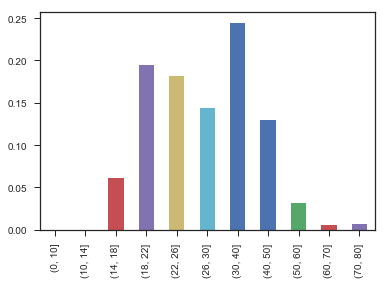

In [18]:
# view distribution of ages from inmate data
view_histogram(mh_df.arrest_age, bins = [0,10,14,18,22,26,30,40,50,60,70,80], normed = True)

In [19]:
mh_df.arrest_age.shape

(1465536,)

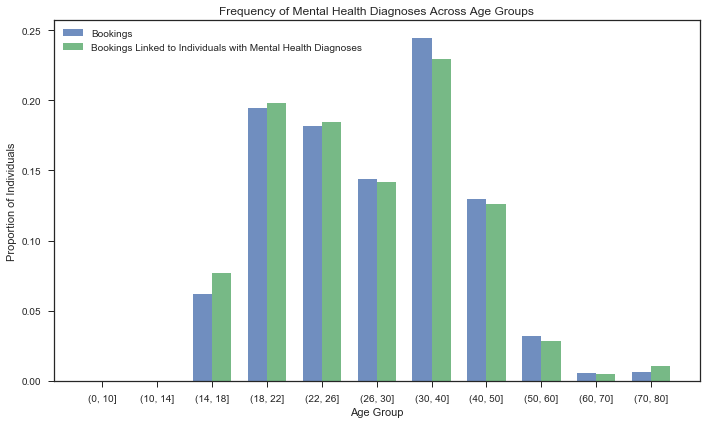

In [ ]:
# plot mental health distribution
all_indiv = pd.cut(mh_df.arrest_age, [0,10,14,18,22,26,30,40,50,60,70,80]).value_counts(normalize=True).sort_index()
mh_indiv = pd.cut(mh_df[mh_df['dx_description'].notnull()]['arrest_age'], [0,10,14,18,22,26,30,40,50,60,70,80]).value_counts(normalize=True).sort_index()
age_labels = tuple([str(i) for i in all_indiv.index])

n_groups = 11

fig, ax = plt.subplots(figsize=(10, 6))

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
# error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, all_indiv, bar_width,
                alpha=opacity,
                label='Bookings')

rects2 = ax.bar(index + bar_width, mh_indiv, bar_width,
                alpha=opacity,
                label='Bookings Linked to Individuals with Mental Health Diagnoses')

ax.set_xlabel('Age Group')
ax.set_ylabel('Proportion of Individuals')
ax.set_title('Frequency of Mental Health Diagnoses Across Age Groups')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels((age_labels))
ax.legend()

fig.tight_layout()
plt.show()

In [ ]:
bucketed = mh_df[mh_df.columns]
bucketed

In [ ]:
bucketed['age_group'] = pd.cut(bucketed.arrest_age, [0,10,14,18,24,30,40,50,60,70,80])

In [ ]:
bucketed

In [ ]:
bucketed[['race','stay_days', 'age_group']].groupby(['age_group','race']).mean().round(1).unstack(level=1).fillna('')

In [ ]:
#cm = sns.light_palette("blue", as_cmap=True)
bucketed[['race','mh_stay_days', 'age_group']].groupby(['age_group','race']).mean().round(1).unstack(level=1).style.background_gradient(cmap='coolwarm', high=0.5, low = 0)

In [131]:
bookings_vs_mh_query='''
with booked as (
SELECT distinct
bkg.mni_no,
bkg.case_no,
bkg.case_type, 
bkg.arresting_agency_type, 
bkg.booking_date, 
bkg.release_date, 
bkg.bail_type, 
bkg.bail_amt, 
bkg.bailed_out,
prg.progressive_bookings
from clean.jocojimsjailbooking_hashed bkg
join (
        SELECT bk.mni_no,
        bk.booking_date, 
        COUNT (bk.mni_no) AS progressive_bookings
        from clean.jocojimsjailbooking_hashed bk
        JOIN clean.jocojimsjailbooking_hashed bk1 ON bk1.mni_no = bk.mni_no AND bk1.booking_date <= bk.booking_date
        group by bk.mni_no, bk.booking_date
        order by bk.mni_no, bk.booking_date) as prg
on bkg.mni_no = prg.mni_no and bkg.booking_date = prg.booking_date),
person_info as (
    select distinct inm.mni_no,
    inm.dedupe_id,
    inm.sex,
    inm.dob,
    inm.race,
    inm.height,
    inm.weight
    from clean.jocojims2inmatedata inm),
charges as (
    SELECT DISTINCT
    ch.mni_no,
    ch.case_no,
    ch.severity_lvl,
    ch.crime_class,
    ch.drug_offense,
    ch.coarse_finding,
    ch.trial_occurred,
    ch.found_or_plead_guilty,
    COUNT(ch.charge_code) AS progressive_charges, 
    cur_charges.unique_chrgs
    FROM clean.jocojimscurrentcharges_hashed ch
    JOIN clean.jocojimscurrentcharges_hashed ch1 ON ch1.mni_no = ch.mni_no AND ch1.case_no <= ch.case_no
    JOIN (select ch.mni_no, ch.case_no, count(distinct ch.charge_code) as unique_chrgs from clean.jocojimscurrentcharges_hashed ch group by ch.mni_no, ch.case_no)  as cur_charges 
    ON cur_charges.mni_no = ch.mni_no AND cur_charges.case_no = ch.case_no 
    GROUP BY ch.mni_no, ch.case_no, ch.severity_lvl, ch.crime_class, ch.drug_offense, 
        ch.coarse_finding, ch.trial_occurred, ch.found_or_plead_guilty, cur_charges.unique_chrgs
    ORDER BY ch.mni_no, ch.case_no, ch.severity_lvl, ch.crime_class, ch.drug_offense, 
        ch.coarse_finding, ch.trial_occurred, ch.found_or_plead_guilty, cur_charges.unique_chrgs)
SELECT distinct
case when person.mni_no is null then bk.mni_no else person.mni_no end,
person.dedupe_id,
person.sex,
person.dob,
person.race,
person.height,
person.weight,
extract(year from age(bk.booking_date::timestamp, person.dob::timestamp))::int as booked_age,
extract(year from age(bk.release_date::timestamp, person.dob::timestamp))::int as release_age,
bk.case_no, 
bk.arresting_agency_type, 
bk.booking_date, 
bk.release_date, 
bk.progressive_bookings,
bk.bail_type, 
bk.bail_amt, 
bk.bailed_out,
DATE_PART('day', bk.release_date::timestamp - bk.booking_date::timestamp)::int as jail_stay_days,
CASE WHEN mh.pri_dx_value IS NOT NULL
THEN 1
ELSE 0
END as mh_diag_dummy,
chrg.severity_lvl,
chrg.crime_class,
chrg.drug_offense,
chrg.coarse_finding,
chrg.trial_occurred,
chrg.found_or_plead_guilty as guilty_dummy,
chrg.unique_chrgs,
chrg.progressive_charges
from booked bk
left outer join charges chrg
on chrg.case_no = bk.case_no and chrg.mni_no = bk.mni_no
left outer join person_info person 
on bk.mni_no = person.mni_no
left outer join clean.jocomentalhealth_hashed mh
on person.dedupe_id = mh.dedupe_id and person.dob = mh.dob 
'''

In [132]:
run_query_save(bookings_vs_mh_query, conn, '/classdata/breakingtheloop/charges_bookings.csv')

In [133]:
bookings_df = pd.read_csv('/classdata/breakingtheloop/charges_bookings.csv', header = 0)

In [134]:
bookings_df.head(10).style

,mni_no,dedupe_id,sex,dob,race,height,weight,booked_age,release_age,case_no,arresting_agency_type,booking_date,release_date,progressive_bookings,bail_type,bail_amt,bailed_out,jail_stay_days,mh_diag_dummy,severity_lvl,crime_class,drug_offense,coarse_finding,trial_occurred,guilty_dummy,unique_chrgs,progressive_charges
0,125794,501148,MALE,1968-01-04,WHITE,600,180,43,43,11CR02770,COUNTY SHERIFF,2011-12-30 00:00:00,2011-12-30 00:00:00,1,SUR,5000,t,0,0,U,INFRACTION,f,GUILTY,t,t,1,1
1,649635,139622,FEMALE,1992-10-08,WHITE,503,125,20,20,12CR02653,CITY,2012-12-18 00:00:00,2012-12-18 00:00:00,2,SUR,2500,t,0,0,A,MISDEMEANOR,f,GUILTY,t,t,1,3
2,634936,541950,MALE,1995-06-02,BLACK OR AFRICAN AMERICAN,604,159,18,18,14CR00251,CITY,2014-02-04 00:00:00,2014-02-14 00:00:00,1,SUR,1000,t,10,0,9,FELONY,f,GUILTY,t,t,2,3
3,422669,55126,MALE,1989-03-14,WHITE,600,154,26,26,15CR01760,COUNTY SHERIFF,2015-07-30 00:00:00,2015-07-30 00:00:00,4,SUR,5000,t,0,0,A,MISDEMEANOR,f,DISMISSED,f,f,3,12
4,487531,84012,MALE,1992-05-19,BLACK OR AFRICAN AMERICAN,600,175,17,17,08JV02243,COUNTY SHERIFF,2010-01-05 00:00:00,2010-02-05 00:00:00,1,nan,nan,f,31,0,7,FELONY,f,DISMISSED,f,f,2,2
5,409728,701947,MALE,1985-01-11,WHITE,511,175,28,28,13CR00590,COUNTY SHERIFF,2013-03-22 00:00:00,2013-03-22 00:00:00,3,SUR,10000,t,0,0,A,MISDEMEANOR,f,DISMISSED,f,f,3,5
6,71017,257669,MALE,1962-05-26,WHITE,508,214,52,52,14CR02533,CITY,2014-11-19 00:00:00,2015-01-27 00:00:00,2,PR,10000,t,69,0,10,FELONY,f,DISMISSED,f,f,3,6
7,663130,286891,FEMALE,1993-05-19,WHITE,505,125,20,20,13DV00882,CITY,2013-07-18 00:00:00,2013-07-18 00:00:00,1,PR,2500,t,0,0,A,MISDEMEANOR,f,GUILTY,t,t,2,2
8,603131,214901,MALE,1978-03-16,WHITE,601,174,32,32,10DV01312,CITY,2010-10-25 00:00:00,2011-01-21 00:00:00,2,PR,7500,t,88,0,9,FELONY,f,GUILTY,t,t,1,4
9,1136,482494,MALE,1962-11-14,WHITE,508,170,50,50,13CR00174,CITY,2013-01-22 00:00:00,2013-08-20 00:00:00,2,nan,nan,f,210,0,U,INFRACTION,f,GUILTY,t,t,3,5


In [135]:
# zips = train_top_dummies(bookings_df, ['zip'], threshold = .8, max_options = 5)

In [136]:
# apply_tops(zips, bookings_df)

In [137]:
# bookings_df.zip.unique()

In [138]:
bookings_df.shape

(130425, 27)

In [78]:
bookings_df[bookings_df.height.isna()].shape

(3658, 30)

In [79]:
bookings_df[bookings_df.height.notnull()].shape

(163647, 30)

In [80]:
def isNaN(num):
    return num != num

In [81]:
def process_int_height(height):
#     print('got int')
    if height < 1000 and height > 99:
        inches = height % 100
        ft = (height - inches) / 100
        inches += (ft * 12)

        return inches

In [82]:
def process_str_height(height):    
    quotes = re.findall(r'\"', height)
    single_quotes = re.findall(r"\'", height)
    if quotes or single_quotes:
        if quotes or single_quotes:
            height = height.replace("'", '"')
            ft, inches = height.split('"')
            inches = int(inches) + (int(ft) * 12)
            return inches
            
    elif len(height.split()) == 2:
        ft, inches = height.split()
        inches = int(inches) + (int(ft) * 12)
        return inches
    
    else:
        if float(height) > 99:
            return process_int_height(int(height))
        elif float(height) < 99:
            return process_float_height(float(height))
        

In [83]:
'''
Original Version
'''

'''

def process_float_height(height):
    if isNaN(height):
        return height
    
    if height > 1000 or height < 99:
        return process_int_height(int(height))
        
    inches = (height % 1)
    if inches > .5:
        inches *= 10
    else:
        inches *= 100

    inches = int(inches)
    ft = height - (height % 1)
    inches += (ft * 12)

    return inches
    
'''


In [ ]:
# Natasha version 5:05pm 
def process_float_height(height):
    if isNaN(height):
        return height
    
    if height > 1000 or height < 99:
        return process_int_height(int(height))
        
    inches = (height % 100)

    inches = int(inches)
    ft = (height - inches) // 100
    
    inches += (ft * 12)

    return inches

In [84]:
def clean_height(height):
    inches = 0
#     print(height)
    try:
        if isNaN(height):
            return height

        elif isinstance(height, str):  
            return process_str_height(height)

        elif isinstance(height, float):
            return process_float_height(height)

        elif isinstance(height, int):
            return process_int_height(height)
    
    except Exception as e:
        print("Unexpected error: {}".format(e))
        
    

In [85]:
bookings_df['height'] = bookings_df['height'].apply(lambda x: clean_height(x))

In [86]:
bookings_df[bookings_df.height.isna()].shape

(3733, 30)

In [87]:
bookings_df[bookings_df.height.notnull()].shape

(163572, 30)

In [88]:
bookings_df.height.head(10)

0    6096.0
1    6096.0
2    6096.0
3    6096.0
4    6096.0
5    6096.0
6    7200.0
7    7200.0
8    7200.0
9    7200.0
Name: height, dtype: float64

In [89]:
bookings_df.loc[6502, 'height']

7224.0

In [27]:
def calc_bmi(ht_in, wt_lb):
    if isNaN(ht_in) and isNaN(wt_lb):
        return ht_in
    
    elif isNaN(ht_in):
        return ht_in
    
    elif isNaN(wt_lb):
        return wt_lb
    
    elif ht_in and wt_lb:
        KG_CONV = 0.453592
        M_CONV = 0.0254

        kg = wt_lb * KG_CONV
        m = ht_in * M_CONV
    
        return  kg / m**2

In [28]:
bookings_df['bmi'] = bookings_df.apply(lambda x: calc_bmi(x['height'], x['weight']), axis=1)

In [30]:
# check for age groups that should not be in data set
bookings_df[bookings_df['booked_age'] < 11]

,mni_no,dedupe_id,sex,dob,race,height,weight,mar_stat,city,zip,...,mh_dicharge_reason,severity_lvl,crime_class,drug_offense,coarse_finding,trial_occurred,guilty_dummy,unique_chrgs,progressive_charges,bmi


In [32]:
# add age group parameter
bookings_df['age_group'] = pd.cut(bookings_df['booked_age'], [0,10,14,18,24,30,40,50,60,70,80])

In [36]:
def view_histogram(df, bins = 10, normed = False):
    pd.cut(df , bins).value_counts(normalize=normed).sort_index().plot(kind='bar')

/usr/local/lib/python3.4/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.2.2 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


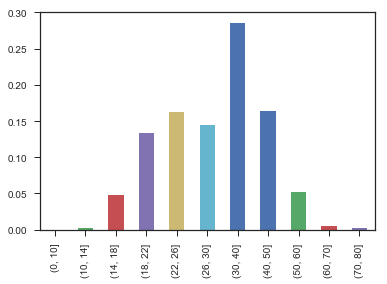

In [37]:
# view distribution of arrest ages from bookings data
view_histogram(bookings_df.booked_age, bins = [0,10,14,18,22,26,30,40,50,60,70,80], normed = True)

In [38]:
bookings_df.head(10).sort_values(by='dedupe_id')

,mni_no,dedupe_id,sex,dob,race,height,weight,mar_stat,city,zip,...,severity_lvl,crime_class,drug_offense,coarse_finding,trial_occurred,guilty_dummy,unique_chrgs,progressive_charges,bmi,age_group
1,98974,299547.0,MALE,1963-01-17,BLACK OR AFRICAN AMERICAN,61.0,130.0,M,KANSAS CITY,64130.0,...,9,FELONY,f,DISMISSED,f,f,1,1,24.563013,"(50, 60]"
2,98974,299547.0,MALE,1963-01-17,BLACK OR AFRICAN AMERICAN,61.0,130.0,M,KANSAS CITY,64130.0,...,9,FELONY,f,GUILTY,t,t,1,1,24.563013,"(50, 60]"
3,98974,299547.0,MALE,1963-01-17,BLACK OR AFRICAN AMERICAN,61.0,130.0,M,KANSAS CITY,64130.0,...,9,FELONY,f,GUILTY,t,t,1,1,24.563013,"(50, 60]"
4,85741,367498.0,MALE,1955-04-04,WHITE,72.0,180.0,S,KC,64112.0,...,U,INFRACTION,f,GUILTY,t,t,2,1,24.412118,"(50, 60]"
5,85741,367498.0,MALE,1955-04-04,WHITE,72.0,180.0,S,KC,64112.0,...,U,INFRACTION,f,DISMISSED,f,f,2,1,24.412118,"(50, 60]"
9,608913,436269.0,MALE,1978-05-24,WHITE,68.0,215.0,M,KANSAS CITY,66103.0,...,4D,FELONY,t,DISMISSED,f,f,3,1,32.690276,"(30, 40]"
0,141326,487227.0,MALE,1974-02-09,WHITE,69.0,145.0,S,KANSAS CITY,66103.0,...,9,FELONY,f,GUILTY,t,t,1,1,21.412520,"(30, 40]"
6,143873,502714.0,MALE,1957-04-21,WHITE,72.0,215.0,M,KANSAS CITY,66106.0,...,A,MISDEMEANOR,f,DISMISSED,f,f,3,1,29.158919,"(50, 60]"
7,143873,502714.0,MALE,1957-04-21,WHITE,72.0,215.0,M,KANSAS CITY,66106.0,...,U,INFRACTION,f,DISMISSED,f,f,3,1,29.158919,"(50, 60]"
8,143873,502714.0,MALE,1957-04-21,WHITE,72.0,215.0,M,KANSAS CITY,66106.0,...,U,INFRACTION,f,GUILTY,t,t,3,1,29.158919,"(50, 60]"


In [39]:
median_bookings = bookings_df[['progressive_bookings', 'age_group']].groupby(['age_group']).median()
mean_bookings = bookings_df[['progressive_bookings', 'age_group']].groupby(['age_group']).mean()
pd.merge(median_bookings, mean_bookings, left_index = True, right_index = True).rename({'progressive_bookings_x': 'Median Bookings', 'progressive_bookings_y': 'Mean Bookings'}, axis = 1).round(2).fillna('')

,Median Bookings,Mean Bookings
age_group,,
"(0, 10]",,
"(10, 14]",1,1.41
"(14, 18]",1,1.82
"(18, 24]",1,1.81
"(24, 30]",1,1.91
"(30, 40]",1,1.81
"(40, 50]",1,1.54
"(50, 60]",1,1.61
"(60, 70]",1,1.33


In [53]:
charges_ct = bookings_df[['crime_class', 'age_group', 'drug_offense']].groupby(['crime_class','age_group']).agg({"drug_offense": 'count'})
charge_pcts = charges_ct.groupby(level=0).apply(lambda x: round(100 * x / float(x.sum()),2))

In [70]:
# view percent of each crime class charged across age groups
charge_distr = charge_pcts.unstack().fillna(0)
charge_distr.rename({'drug_offense': 'bookings'}, axis = 1, inplace = True)
charge_distr

bookings                                                        \
age_group   (10, 14] (14, 18] (18, 24] (24, 30] (30, 40] (40, 50] (50, 60]   
crime_class                                                                  
FELONY          0.06     4.08    21.60    24.11    28.73    16.32     4.15   
INFRACTION      0.00     0.26     7.86    20.57    36.89    22.95    10.19   
MISDEMEANOR     0.42     5.95    22.47    22.72    27.29    15.40     5.24   

                               
age_group   (60, 70] (70, 80]  
crime_class                    
FELONY          0.32     0.63  
INFRACTION      1.18     0.10  
MISDEMEANOR     0.49     0.03

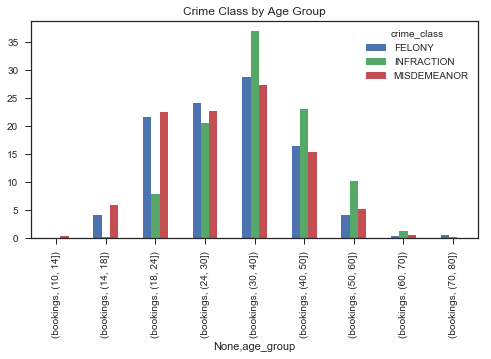

In [89]:

charge_distr.transpose().plot(kind = 'bar', figsize = (8, 4), title = 'Crime Class by Age Group')
plt.xlabel = 'Crime Class by Age'

In [90]:
age_chrg_cts = bookings_df[['crime_class', 'age_group', 'drug_offense']].groupby(['age_group', 'crime_class']).agg({"drug_offense": 'count'})
age_charge_pcts = age_chrg_cts.groupby(level=0).apply(lambda x: round(100 * x / float(x.sum()),2)).unstack().fillna(0)

In [91]:
# view percentage of age group charged with each class of of crime
age_charge_pcts

drug_offense                       
crime_class       FELONY INFRACTION MISDEMEANOR
age_group                                      
(10, 14]            7.79       0.00       92.21
(14, 18]           30.22       0.38       69.40
(18, 24]           36.89       2.63       60.48
(24, 30]           37.72       6.30       55.98
(30, 40]           36.39       9.15       54.46
(40, 50]           36.21       9.97       53.83
(50, 60]           28.84      13.85       57.31
(60, 70]           24.03      17.61       58.36
(70, 80]           89.85       2.70        7.46

In [92]:
# maps 98% of MNI numbers in booking table
# does NOT verify birth date as booking table does not include it
booking_mnis_mapped_query='''
select bk.mni_no,
case when inm.dedupe_id is null
then nix.dedupe_id
else inm.dedupe_id
end
from clean.jocojimsjailbooking_hashed bk
left join clean.jocojims2inmatedata inm
on bk.mni_no = inm.mni_no 
left join clean.jocojims2nameindexdata nix 
on inm.mni_no = nix.mni_no
'''

In [93]:
run_query_save(booking_mnis_mapped_query, conn, '/classdata/breakingtheloop/booking_id_mapping.csv')

In [94]:
booking_ids = pd.read_csv('/classdata/breakingtheloop/data/booking_id_mapping.csv', header = 0)

In [95]:
booking_ids.head()

,mni_no,dedupe_id
0,627734,258641.0
1,692561,623267.0
2,692561,623267.0
3,697877,482947.0
4,85741,367498.0


In [48]:
### stil returning overall max vs max as of booking date, will continue working on this
days_since_mh = '''
select mh.dedupe_id, mh.patid, mh.dob, last_mh.book_dt, max(last_mh.dschrg_date) as latest, 
DATE_PART('day', last_mh.book_dt::timestamp - max(last_mh.dschrg_date)::timestamp)::int as days_since_mh
from clean.jocomentalhealth_hashed mh
join (
    select distinct mh2.dedupe_id, mh2.patid, bk_dates.book_dt, mh2.dschrg_date 
    from clean.jocomentalhealth_hashed mh2
    join (select bk.mni_no, 
            case when inm.bk_dt is null
            then bk.booking_date
            else inm.bk_dt
            end as book_dt,
            case when inm.dedupe_id is null
            then nix.dedupe_id
            else inm.dedupe_id
            end,
            case when inm.dob is null
            then nix.dob
            else inm.dob
            end
            from clean.jocojims2inmatedata inm
            left join clean.jocojimsjailbooking_hashed bk
            on bk.mni_no = inm.mni_no 
            left join clean.jocojims2nameindexdata nix 
            on inm.mni_no = nix.mni_no) as bk_dates 
    on mh2.dedupe_id = bk_dates.dedupe_id and mh2.dob = bk_dates.dob and bk_dates.book_dt >= mh2.dschrg_date) as last_mh
on last_mh.dedupe_id = mh.dedupe_id and last_mh.patid = mh.patid
group by mh.dedupe_id, mh.patid, mh.dob, last_mh.book_dt
order by mh.dedupe_id, last_mh.book_dt 
'''

In [49]:
run_query_save(days_since_mh, conn, '/classdata/breakingtheloop/days_since.csv')

In [50]:
days_df = pd.read_csv('/classdata/breakingtheloop/days_since.csv', header = 0)

In [51]:
days_df.shape

(6947, 6)

In [53]:
days_df.head()

,dedupe_id,patid,dob,book_dt,latest,days_since_mh
0,218,137771,1961-07-23 00:00:00,2014-12-10 00:00:00,2013-12-20 00:00:00,355
1,218,137771,1961-07-23 00:00:00,2015-05-07 00:00:00,2013-12-20 00:00:00,503
2,315,41623,1975-05-11 00:00:00,2011-03-18 00:00:00,2011-02-23 00:00:00,23
3,315,41623,1975-05-11 00:00:00,2011-05-02 00:00:00,2011-02-23 00:00:00,68
4,607,93096,1968-12-17 00:00:00,2011-08-08 00:00:00,2011-01-25 00:00:00,195


In [54]:
days_df['mh_last_365'] = days_df['days_since_mh'].apply(lambda x: 1 if x <= 365 else 0)

In [55]:
days_df.head()

,dedupe_id,patid,dob,book_dt,latest,days_since_mh,mh_last_365
0,218,137771,1961-07-23 00:00:00,2014-12-10 00:00:00,2013-12-20 00:00:00,355,1
1,218,137771,1961-07-23 00:00:00,2015-05-07 00:00:00,2013-12-20 00:00:00,503,0
2,315,41623,1975-05-11 00:00:00,2011-03-18 00:00:00,2011-02-23 00:00:00,23,1
3,315,41623,1975-05-11 00:00:00,2011-05-02 00:00:00,2011-02-23 00:00:00,68,1
4,607,93096,1968-12-17 00:00:00,2011-08-08 00:00:00,2011-01-25 00:00:00,195,1


In [56]:
days_df[days_df['dedupe_id'] == 619]

,dedupe_id,patid,dob,book_dt,latest,days_since_mh,mh_last_365
5,619,86425,1989-10-25 00:00:00,2013-10-20 00:00:00,2013-09-23 00:00:00,27,1
6,619,86425,1989-10-25 00:00:00,2014-02-01 00:00:00,2013-09-23 00:00:00,131,1
7,619,86425,1989-10-25 00:00:00,2015-05-20 00:00:00,2013-09-23 00:00:00,604,0


In [139]:
bookings_df[bookings_df['dedupe_id'] == 619]

,dedupe_id,mni_no,dob,booking_date
3799,619.0,380717,1989-10-25,2013-07-12 00:00:00
9327,619.0,380717,1989-10-25,2014-02-01 00:00:00
10028,619.0,380717,1989-10-25,2014-02-01 00:00:00
10300,619.0,380717,1989-10-25,2015-05-20 00:00:00
12019,619.0,380717,1989-10-25,2011-03-30 00:00:00
12690,619.0,380717,1989-10-25,2015-05-20 00:00:00
13568,619.0,380717,1989-10-25,2011-03-30 00:00:00
15342,619.0,380717,1989-10-25,2015-05-20 00:00:00
15578,619.0,380717,1989-10-25,2015-05-20 00:00:00
17663,619.0,380717,1989-10-25,2013-07-12 00:00:00


In [190]:
bookings_df.columns

Index(['mni_no', 'dedupe_id', 'sex', 'dob', 'race', 'height', 'weight',
       'mar_stat', 'city', 'zip', 'booked_age', 'release_age', 'case_no',
       'case_type', 'arresting_agency_type', 'booking_date', 'release_date',
       'progressive_bookings', 'bail_type', 'bail_amt', 'bailed_out',
       'jail_stay_days', 'mh_diag_dummy', 'mh_admit_dt', 'mh_dschg_dt',
       'mh_dicharge_reason', 'severity_lvl', 'crime_class', 'drug_offense',
       'coarse_finding', 'trial_occurred', 'guilty_dummy', 'unique_chrgs',
       'progressive_charges', 'bmi', 'age_group'],
      dtype='object')

In [224]:
test = pd.merge(bookings_df, days_df[['dedupe_id', 'case_no', 'booking_date','days_since_mh', 'mh_last_365']], on=['case_no'], how='outer')
test.shape

(318824, 38)

In [17]:
def train_top_dummies(train_df, cols_to_narrow, threshold, max_options = 5):
    values_to_keep = []
    counter = 1
    dummies_dict = {}

    for col in cols_to_narrow:
        col_sum = train_df[col].value_counts().sum()
        top = train_df[col].value_counts().nlargest(max_options)
        top_idx = list(top.index)
        top_value = 0
        num_dummies = int(0)

        while ((top_value / col_sum) < threshold) & (num_dummies < max_options):
            top_value += top[top_idx[num_dummies]]

            num_dummies += int(1)

        keep_dummies = top_idx[:num_dummies]
        dummies_dict[col] = keep_dummies
        
    counter += 1
    values_to_keep.append(dummies_dict)

    return values_to_keep



def apply_tops(values_to_keep, train_df, test_df = None):
    counter = 0
    for set_dict in values_to_keep:
        counter += 1
        for col, vals in set_dict.items():
            train_df.loc[~train_df[col].isin(vals), col] = 'Other'
            if test_df is not None:
                test_df.loc[~test_df[col].isin(vals), col] = 'Other'